## LEXICON METHOD IMPLEMENTATION

In [2]:
import torch

In [3]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [4]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [5]:
torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

mps:0
mps:0


## PRE-PROCESSING

In [29]:
# Basic utilities
import os
import platform
import re

# Data handling and manipulation
import numpy as np
import pandas as pd
import ast

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from textblob import TextBlob
import contractions

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report)



In [7]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: arm64
Platform: macOS-13.5-arm64-i386-64bit
Mac Version: ('13.5', ('', '', ''), 'arm64')
Processor: i386
Python Version: 3.11.4


In [8]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.19.2
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.7.0
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


In [9]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project Code/Tweets.csv'
df = pd.read_csv(data_pth)
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [10]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64
neutral     40.457043
positive    31.228849
negative    28.314108
Name: sentiment, dtype: float64


In [11]:
def check_missing_data(dataframe):
    """
    Check for missing data in the dataframe.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe to inspect.
    
    Returns:
    - pd.Series: A series containing counts of missing data for each column.
    """
    return dataframe.isnull().sum()

# Display the number of missing values for each column
print("Missing Values:\n", check_missing_data(df))

# Remove rows with missing values
df.dropna(inplace=True)
print(f"Post Filtering Step-1: Total Rows - {len(df)}")

Missing Values:
 textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
Post Filtering Step-1: Total Rows - 27480


In [12]:
def custom_handle_contractions(text):
    """
    Expand contractions in the provided text using a predefined contractions dictionary.
    This function handles contractions formed both with standard apostrophes and backticks.
    
    Args:
    - text (str): The input text containing contractions.
    
    Returns:
    - str: The input text with all recognized contractions expanded.
    
    """
    
    # Define a dictionary of contractions and their expanded forms
    contractions_dict = contractions.contractions_dict
    
    # Replace the contractions with their expanded form
    for contraction, expansion in contractions_dict.items():
        # Handle both apostrophes and backticks
        text = text.replace(contraction, expansion)
        text = text.replace(contraction.replace("'", "`"), expansion)

    return text

# Applying it to the DataFrame
df['text'] = df['text'].apply(custom_handle_contractions)


In [13]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I would have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why could not they put them on ...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I have wondered about rake to. The client ha...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [14]:
def clean_text(text):
    """
    Clean the provided text by removing URLs, mentions, numbers, hashtags, non-ASCII characters, and converting to lowercase.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The cleaned text.
    """
    text = text.lower() 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'#\S+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text

df['cleaned_tweets'] = df['text'].apply(clean_text)


In [15]:
def retain_required_columns(df, required_columns):
    """
    Retains only the specified required columns in the DataFrame and drops all others.
    
    Args:
    - df (pd.DataFrame): The input DataFrame.
    - required_columns (list): List of column names to retain.
    
    Returns:
    - pd.DataFrame: DataFrame containing only the required columns.
    """
    
    # Check if required columns are present in the dataframe
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"The following required columns are not present in the DataFrame: {missing_columns}")
    
    return df[required_columns]


df = retain_required_columns(df, ['sentiment', 'cleaned_tweets'])

In [16]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [17]:
# Detect all duplicates based on the 'cleaned_text' column
duplicates_mask = df.duplicated(subset='cleaned_tweets', keep=False)

# Remove all rows with duplicate 'cleaned_text'
df = df[~duplicates_mask]

In [18]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [19]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11030
positive     8435
negative     7735
Name: sentiment, dtype: int64
neutral     40.551471
positive    31.011029
negative    28.437500
Name: sentiment, dtype: float64


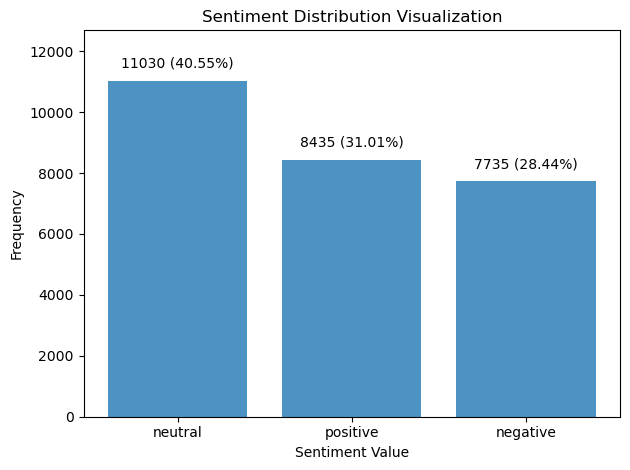

In [20]:
import matplotlib.pyplot as plt

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = df['sentiment'].value_counts()
sentiment_ratio = df['sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

In [21]:
#!pip install textblob

In [22]:
# --- Data Preparation ---

# Map the sentiments to numerical values
target_map = {'neutral':2,'positive':0,'negative':1}
df = df.copy()
df.loc[:, 'target'] = df['sentiment'].map(target_map)
df.head()

,sentiment,cleaned_tweets,target
0,neutral,i would have responded if i were going,2
1,negative,sooo sad i will miss you here in san diego,1
2,negative,my boss is bullying me,1
3,negative,what interview leave me alone,1
4,negative,sons of why could not they put them on the r...,1


In [23]:
# Extracting sentences and their labels
X, y = df['cleaned_tweets'].values, df['target'].values

# Splitting the data into training, validation, and test sets (70-15-15 split)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [24]:
def display_report(Y_true, Y_pred, dataset_type="Training"):
    """
    Print out the classification report and display the confusion matrix.
    :param Y_true: true labels
    :param Y_pred: predicted labels
    :param dataset_type: a string specifying the dataset type ("Training", "Validation", or "Test")
    :return: None
    """
    # Print classification report
    print(f"{dataset_type} Classification Report:\n{classification_report(Y_true, Y_pred, digits=4)}\n")

    # Display the confusion matrix using a heatmap
    cm = confusion_matrix(Y_true, Y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{dataset_type} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    

In [37]:
def compute_FPR_spec_metrics(cm, labels=["positive", "negative", "neutral"]):
    """
    Compute specificity, FPR, precision for each class, and the overall accuracy given a 3x3 confusion matrix.
    Also, computes weighted and macro average for FPR and specificity.

    Args:
    - cm (numpy array): 3x3 confusion matrix
    - labels (list): List of class labels in order

    Returns:
    None. It will print the results directly.
    """
    
    specificities = []
    fprs = []
    precisions = []

    for i in range(3):
        tp = cm[i, i]
        tn = sum(cm[j, j] for j in range(3) if j != i)
        fp = sum(cm[j, i] for j in range(3) if j != i)
        fn = sum(cm[i, j] for j in range(3) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        precision = tp / (tp + fp) if tp + fp != 0 else 0
        
        specificities.append(round(specificity, 4))
        fprs.append(round(fpr, 4))
        precisions.append(round(precision, 4))
    
    # Print the class values with their corresponding metrics
    for i, label in enumerate(labels):
        print(f"Metrics for class {label} (Class value: {i}):")
        print(f"Specificity: {specificities[i]}")
        print(f"FPR: {fprs[i]}")
        print(f"Precision: {precisions[i]}\n")

    # Calculate overall accuracy
    accuracy = round(np.trace(cm) / np.sum(cm), 4)
    print(f"Overall accuracy: {accuracy}")

    # Calculate true values for each class for weighting purposes
    true_values = np.sum(cm, axis=1)
    total_true_values = np.sum(true_values)

    # Calculate weighted average specificity and FPR
    weighted_avg_spec = round(sum(specificities[i] * true_values[i] for i in range(3)) / total_true_values, 4)
    weighted_avg_fpr = round(sum(fprs[i] * true_values[i] for i in range(3)) / total_true_values, 4)

    # Calculate macro average specificity and FPR
    macro_avg_spec = round(np.mean(specificities), 4)
    macro_avg_fpr = round(np.mean(fprs), 4)

    print(f"Weighted average specificity: {weighted_avg_spec}")
    print(f"Weighted average FPR: {weighted_avg_fpr}")
    print(f"Macro average specificity: {macro_avg_spec}")
    print(f"Macro average FPR: {macro_avg_fpr}\n")


In [26]:
def display_sentences(X, Y_true, Y_pred):
    """
    Display samples for true positives, true negatives, true neutrals, and the various false classifications.
    :param X: The text sentences
    :param Y_true: true labels
    :param Y_pred: predicted labels
    :return: None
    """    

    # Extracting sample indices for different scenarios
    true_positives = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == pred == 0]
    true_neutrals = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == pred == 2]
    true_negatives = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == pred == 1]

    # For false classifications
    false_positives_from_neutral = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 2 and pred == 0]
    false_positives_from_negative = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 1 and pred == 0]

    false_neutrals_from_positive = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 0 and pred == 2]
    false_neutrals_from_negative = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 1 and pred == 2]

    false_negatives_from_positive = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 0 and pred == 1]
    false_negatives_from_neutral = [i for i, (true, pred) in enumerate(zip(Y_true, Y_pred)) if true == 2 and pred == 1]

    # Displaying the samples
    print("True Positives:\n", [X[i] for i in true_positives[:5]])
    print("True Neutrals:\n", [X[i] for i in true_neutrals[:5]])
    print("True Negatives:\n", [X[i] for i in true_negatives[:5]])

    # Display the sentence and misclassifications
    print("\nFalse Positives (Neutral guessed as Positive):\n")
    for i in false_positives_from_neutral[:5]:
        print(f"Sentence: {X[i]}")
    
    print("\nFalse Positives (Negative guessed as Positive):\n")
    for i in false_positives_from_negative[:5]:
        print(f"Sentence: {X[i]}")

    print("\nFalse Neutrals (Positive guessed as Neutral):\n")
    for i in false_neutrals_from_positive[:5]:
        print(f"Sentence: {X[i]}")

    print("\nFalse Neutrals (Negative guessed as Neutral):\n")
    for i in false_neutrals_from_negative[:5]:
        print(f"Sentence: {X[i]}")

    print("\nFalse Negatives (Positive guessed as Negative):\n")
    for i in false_negatives_from_positive[:5]:
        print(f"Sentence: {X[i]}")

    print("\nFalse Negatives (Neutral guessed as Negative):\n")
    for i in false_negatives_from_neutral[:5]:
        print(f"Sentence: {X[i]}")


# TEXT BLOB IMPLEMENTATION

In [32]:
def analyze_sentiment(text):
    """
    Analyze sentiment of a given text using TextBlob's sentiment polarity.
    :param text: input text to be analyzed
    :return: sentiment label encoded as integer (0: positive, 1: negative, 2: neutral)
    """
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 0  # 'positive'
    elif analysis.sentiment.polarity == 0:
        return 2  # 'neutral'
    else:
        return 1  # 'negative'

In [33]:
# Predicting sentiments
Y_train_pred = [analyze_sentiment(text) for text in X_train]
Y_val_pred = [analyze_sentiment(text) for text in X_val]
Y_test_pred = [analyze_sentiment(text) for text in X_test]

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.5396    0.7879    0.6405      1254
           1     0.6519    0.4734    0.5485      1147
           2     0.6165    0.5200    0.5641      1679

    accuracy                         0.5892      4080
   macro avg     0.6027    0.5937    0.5844      4080
weighted avg     0.6028    0.5892    0.5832      4080




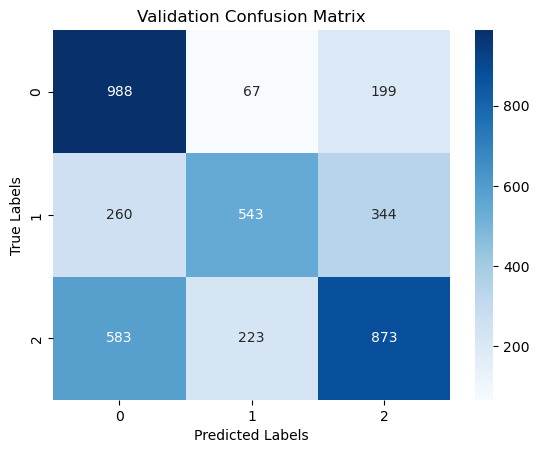

Test Classification Report:
              precision    recall  f1-score   support

           0     0.5477    0.7810    0.6439      1265
           1     0.6839    0.4657    0.5541      1194
           2     0.5926    0.5349    0.5623      1621

    accuracy                         0.5909      4080
   macro avg     0.6081    0.5938    0.5867      4080
weighted avg     0.6054    0.5909    0.5852      4080




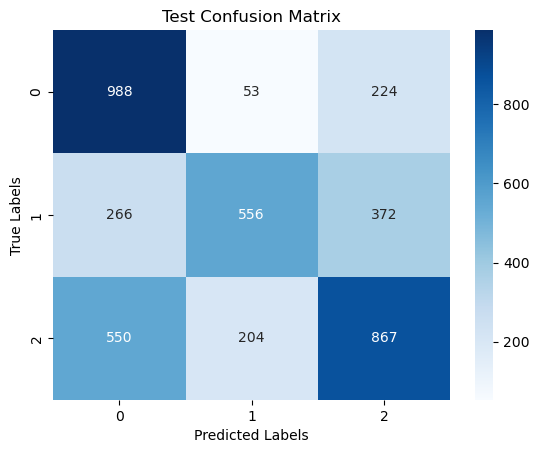

In [34]:
# Evaluating on the validation and test sets
display_report(Y_val, Y_val_pred, "Validation")
display_report(Y_test, Y_test_pred, "Test")

In [38]:
cm = np.array([[988, 53, 224], 
               [266, 556, 372], 
               [550, 204, 867]])

compute_FPR_spec_metrics(cm)


Metrics for class positive (Class value: 0):
Specificity: 0.6356
FPR: 0.3644
Precision: 0.5477

Metrics for class negative (Class value: 1):
Specificity: 0.8783
FPR: 0.1217
Precision: 0.6839

Metrics for class neutral (Class value: 2):
Specificity: 0.7215
FPR: 0.2785
Precision: 0.5926

Overall accuracy: 0.5909
Weighted average specificity: 0.7408
Weighted average FPR: 0.2592
Macro average specificity: 0.7451
Macro average FPR: 0.2549



In [35]:
# Evaluating on the validation and test sets
display_sentences(X_test, Y_test, Y_test_pred)

True Positives:
 [' touch my hand video  simply amazing  love it', ' two macaroons go into a barone says oh your a nut  wow i need to get out more', 'spiderwoman she is an amazing mum gr blogger gr mentor  on top of that climbs walls   via ', 'movie is pretty interesting actually gonna finish watching it  probably seeing star trek tomorrow  zq lol', ' that would be soooooo much and geeky to the ultimate level but i work  to am']
True Neutrals:
 ['check it out check it out check it out', ' nothing stayed home', 'omg days till st state exam', ' whwha hacky sack plans sans jackie', '  we drank ours away may day bank holiday today']
True Negatives:
 ['back at the vet and it is not good', ' i like to support my friends  its sad that i am your only friend though', 'oh i hate friday evening', '_radio yeah s i feel all funny cause i have not slept enough  i woke my mum up cause i was singing she is not impressed s you', ' sorry again i do not have a twitter ap on my phone so i only text to it 

# VADER IMPLEMENTATION

In [36]:
# --- Sentiment Analysis using VADER ---

sia = SentimentIntensityAnalyzer()

def analyze_vader_sentiment(text):
    """
    Analyze the sentiment of a text using VADER's polarity scores.
    :param text: A string containing the text to be analyzed.
    :return: An integer representing the sentiment (0 for positive, 1 for negative, 2 for neutral).
    """
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return 0  # 'positive'
    elif score < -0.05:
        return 1  # 'negative'
    else:
        return 2  # 'neutral'

In [37]:
# Predict sentiments for the datasets
Y_train_pred = [analyze_vader_sentiment(text) for text in X_train]
Y_val_pred = [analyze_vader_sentiment(text) for text in X_val]
Y_test_pred = [analyze_vader_sentiment(text) for text in X_test]


Validation Classification Report:
              precision    recall  f1-score   support

           0     0.5673    0.8772    0.6890      1254
           1     0.7024    0.6234    0.6605      1147
           2     0.7195    0.4812    0.5767      1679

    accuracy                         0.6429      4080
   macro avg     0.6631    0.6606    0.6421      4080
weighted avg     0.6679    0.6429    0.6348      4080




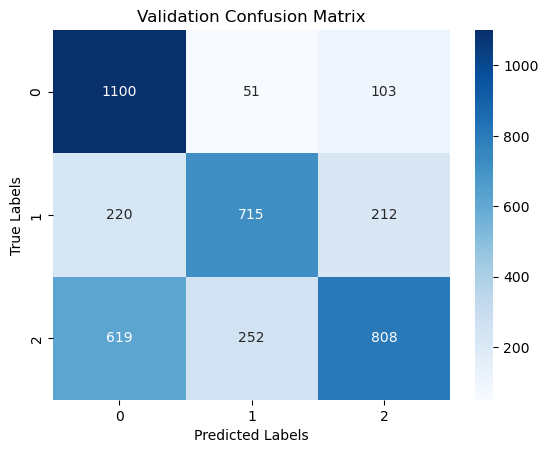

Test Classification Report:
              precision    recall  f1-score   support

           0     0.5663    0.8640    0.6842      1265
           1     0.7016    0.6064    0.6505      1194
           2     0.6878    0.4744    0.5615      1621

    accuracy                         0.6338      4080
   macro avg     0.6519    0.6483    0.6321      4080
weighted avg     0.6542    0.6338    0.6256      4080




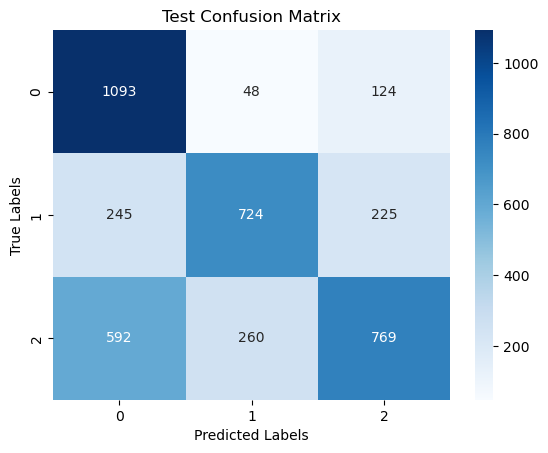

In [38]:
# Evaluating on the validation and test sets
display_report(Y_val, Y_val_pred, "Validation")
display_report(Y_test, Y_test_pred, "Test")

In [39]:
cm = np.array([[1093, 48, 124], 
               [245, 724, 225], 
               [592, 260, 769]])

compute_FPR_spec_metrics(cm)

Metrics for class positive (Class value: 0):
Specificity: 0.6408
FPR: 0.3592
Precision: 0.5663

Metrics for class negative (Class value: 1):
Specificity: 0.8581
FPR: 0.1419
Precision: 0.7016

Metrics for class neutral (Class value: 2):
Specificity: 0.8389
FPR: 0.1611
Precision: 0.6878

Overall accuracy: 0.6338
Weighted average specificity: 0.7831
Weighted average FPR: 0.2169
Macro average specificity: 0.7793
Macro average FPR: 0.2207



In [39]:
# Evaluating on the validation and test sets
display_sentences(X_test, Y_test, Y_test_pred)

True Positives:
 [' yay to som i no on twitterslowly slowly rest of the grade will come aroundhah  i hope ur ready for my constant tweets', ' touch my hand video  simply amazing  love it', ' two macaroons go into a barone says oh your a nut  wow i need to get out more', 'spiderwoman she is an amazing mum gr blogger gr mentor  on top of that climbs walls   via ', 'movie is pretty interesting actually gonna finish watching it  probably seeing star trek tomorrow  zq lol']
True Neutrals:
 ['check it out check it out check it out', ' nothing stayed home', 'has roughly cleaned his room and now is heading to pablos to read', 'omg days till st state exam', ' whwha hacky sack plans sans jackie']
True Negatives:
 ['back at the vet and it is not good', '_cass my throat hurts today  blahhh', 'oh i hate friday evening', 'i have such a sore head', ' sorry again i do not have a twitter ap on my phone so i only text to it i can only reply on the internet for now']

False Positives (Neutral guessed as 